In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [15]:
train = pd.read_parquet('train-00000-of-00001-daf190ce720b3dbb.parquet', engine='pyarrow')
test = pd.read_parquet('test-00000-of-00001-fa9b3e8ade89a333.parquet', engine='pyarrow')
df = pd.concat([train, test], ignore_index=True)
df

,text,label
0,hey I am looking for Xray baggage datasets can...,not_spam
1,"""Get rich quick! Make millions in just days wi...",spam
2,URGENT MESSAGE: YOU WON'T BELIEVE WHAT WE HAVE...,spam
3,[Google AI Blog: Contributing Data to Deepfake...,not_spam
4,Trying to see if anyone already has timestamps...,not_spam
...,...,...
10895,Is it good and usable?\n\n[https://www.uscompa...,not_spam
10896,I'm not sure if this is the absolute best sub ...,not_spam
10897,Would love if anyone knew of any really good d...,not_spam
10898,"Fields = Hashrate, VRAM, TDP, MSRP, Profit/day",not_spam


In [16]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10900 entries, 0 to 10899
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    10900 non-null  object
 1   label   10900 non-null  object
dtypes: object(2)
memory usage: 170.4+ KB


,text,label
count,10900,10900
unique,10662,2
top,"Show off, complain, and generally have a chat ...",spam
freq,14,5500


In [17]:
df = df.drop_duplicates()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10662 entries, 0 to 10899
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    10662 non-null  object
 1   label   10662 non-null  object
dtypes: object(2)
memory usage: 249.9+ KB


In [18]:
df['label'].value_counts()

label
spam        5500
not_spam    5162
Name: count, dtype: int64

# EDA

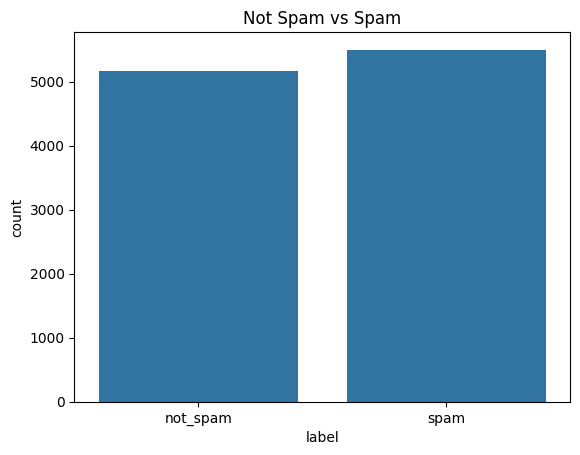

In [19]:
sns.countplot(data=df, x='label')
plt.title('Not Spam vs Spam')
plt.show()

/tmp/ipykernel_33196/43196997.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['message_length'] = df['text'].apply(len)


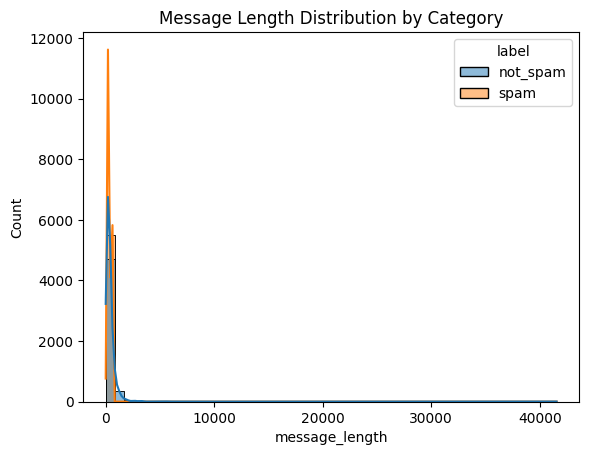

In [20]:
df['message_length'] = df['text'].apply(len)

# Plotting distribution of message lengths
sns.histplot(data=df, x='message_length', hue='label', bins=50, kde=True)
plt.title("Message Length Distribution by Category")
plt.show()

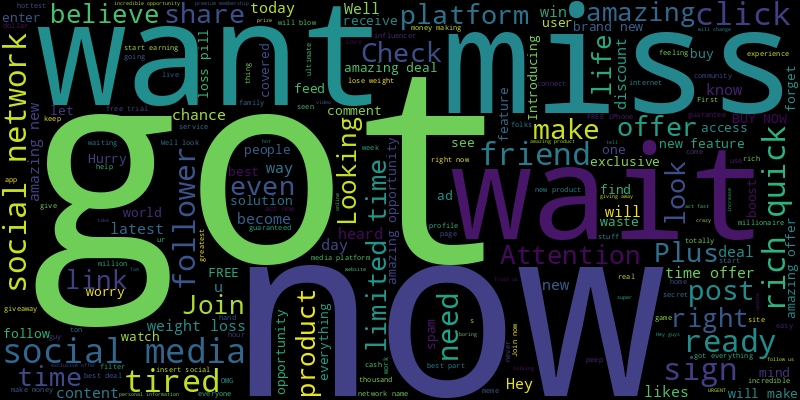

In [21]:
from wordcloud import WordCloud

spam_words = ' '.join(df[df['label'] == 'spam']['text'])
ham_words = ' '.join(df[df['label'] == 'not_spam']['text'])

# Spam WordCloud
WordCloud(width=800, height=400).generate(spam_words).to_image()

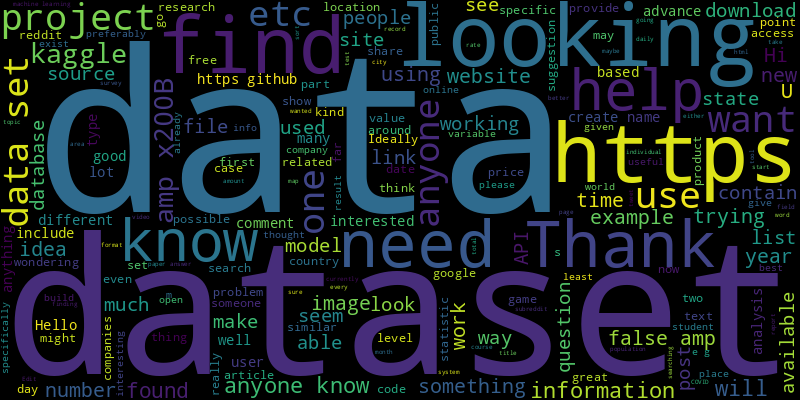

In [22]:
# Ham WordCloud
WordCloud(width=800, height=400).generate(ham_words).to_image()

# Feature Engineering

In [23]:
import re, string
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

In [24]:
# Clean text
def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
    text = re.sub(r'\d+', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub(r'\s+', ' ', text).strip()
    return text

X = df['text'].apply(clean_text)

le = LabelEncoder()
y = le.fit_transform(df['label'])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=df['label']
)

In [25]:
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# Model

In [26]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score

In [27]:
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train_vec, y_train)

# Predict
y_pred = clf.predict(X_test_vec)

# Evaluation
print("Accuracy: ", accuracy_score(y_test, y_pred))
print("F1 Score: ", f1_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

Accuracy:  0.9957805907172996
F1 Score:  0.9958997722095672
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1033
           1       1.00      0.99      1.00      1100

    accuracy                           1.00      2133
   macro avg       1.00      1.00      1.00      2133
weighted avg       1.00      1.00      1.00      2133

[[1031    2]
 [   7 1093]]


In [28]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train_vec, y_train)
y_pred_xgb = xgb_model.predict(X_test_vec)

print("Accuracy: ", accuracy_score(y_test, y_pred_xgb))
print("F1 Score: ", f1_score(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))
print(confusion_matrix(y_test, y_pred_xgb))

/home/eatlunches/Documents/Codes/Machine-Learning/.venv/lib64/python3.13/site-packages/xgboost/training.py:183: UserWarning: [13:01:46] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Accuracy:  0.993905297702766
F1 Score:  0.9940720474236207
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1033
           1       1.00      0.99      0.99      1100

    accuracy                           0.99      2133
   macro avg       0.99      0.99      0.99      2133
weighted avg       0.99      0.99      0.99      2133

[[1030    3]
 [  10 1090]]


# Cross Validation

In [29]:
from sklearn.model_selection import cross_val_score

In [39]:
scores = cross_val_score(RandomForestClassifier(), X_train_vec, y_train, cv=5, scoring='accuracy')
print("Random Forest CV Accuracy:", (scores.mean()))

Random Forest CV Accuracy: 0.9940204831661928


In [40]:
scores = cross_val_score(XGBClassifier(), X_train_vec, y_train, cv=5, scoring='accuracy')
print("XGBoost Accuracy:", (scores.mean()))

XGBoost Accuracy: 0.9909719362058356


Exception ignored in: <function ResourceTracker.__del__ at 0x7ff3f7049300>
Traceback (most recent call last):
  File "/usr/lib64/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/usr/lib64/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/usr/lib64/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x7fe92a359300>
Traceback (most recent call last):
  File "/usr/lib64/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/usr/lib64/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/usr/lib64/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x7f504ae51300>
Traceback (most recent call last):
  File "/usr/lib64/python3.13/multip

# Tuning

In [32]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [33]:
rf_params = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True, False]
}

# Initialize model
rf = RandomForestClassifier(random_state=42)

# Grid search
rf_grid = GridSearchCV(rf, rf_params, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
rf_grid.fit(X_train_vec, y_train)

# Best model
print("Best RF Parameters:", rf_grid.best_params_)
print("Best RF Score:", rf_grid.best_score_)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


Best RF Parameters: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Best RF Score: 0.9950757203315537


In [34]:
y_pred_rf = rf_grid.predict(X_test_vec)
print("Accuracy: ", accuracy_score(y_test, y_pred_rf))
print("F1 Score: ", f1_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))
print(confusion_matrix(y_test, y_pred_rf))

Accuracy:  0.9948429442100328
F1 Score:  0.99498861047836
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1033
           1       1.00      0.99      0.99      1100

    accuracy                           0.99      2133
   macro avg       0.99      0.99      0.99      2133
weighted avg       0.99      0.99      0.99      2133

[[1030    3]
 [   8 1092]]


In [35]:
# Parameter grid
xgb_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2],
    'reg_alpha': [0, 0.1, 1],
    'reg_lambda': [1, 1.5, 2]
}

# Initialize model
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Randomized search
xgb_random = RandomizedSearchCV(xgb, xgb_params, n_iter=50, cv=5,
                                verbose=1, random_state=42, n_jobs=-1, scoring='accuracy')
xgb_random.fit(X_train_vec, y_train)

# Best model
print("Best XGB Parameters:", xgb_random.best_params_)
print("Best XGB Score:", xgb_random.best_score_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


/home/eatlunches/Documents/Codes/Machine-Learning/.venv/lib64/python3.13/site-packages/xgboost/training.py:183: UserWarning: [13:04:13] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/eatlunches/Documents/Codes/Machine-Learning/.venv/lib64/python3.13/site-packages/xgboost/training.py:183: UserWarning: [13:04:14] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/eatlunches/Documents/Codes/Machine-Learning/.venv/lib64/python3.13/site-packages/xgboost/training.py:183: UserWarning: [13:04:14] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/eatlunches/Documents/Codes/Machine-Learning/.venv/lib64/python3.13/site-packages/xgboost/training.py:183: UserWarning: [13:04:14] WARNING: /workspace/src/learner.cc:738: 
Paramet

Best XGB Parameters: {'subsample': 0.7, 'reg_lambda': 2, 'reg_alpha': 1, 'n_estimators': 300, 'max_depth': 7, 'learning_rate': 0.2, 'gamma': 0.1, 'colsample_bytree': 0.8}
Best XGB Score: 0.9914408693828578


In [36]:
# Evaluate
y_pred_xgb = xgb_random.predict(X_test_vec)
print("Accuracy: ", accuracy_score(y_test, y_pred_xgb))
print("F1 Score: ", f1_score(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))
print(confusion_matrix(y_test, y_pred_xgb))

Accuracy:  0.9929676511954993
F1 Score:  0.9931662870159453
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1033
           1       1.00      0.99      0.99      1100

    accuracy                           0.99      2133
   macro avg       0.99      0.99      0.99      2133
weighted avg       0.99      0.99      0.99      2133

[[1028    5]
 [  10 1090]]


# Save

In [37]:
import joblib

joblib.dump(rf_grid, 'random_forest_model.pkl')
joblib.dump(xgb_random, 'xgboost_model.pkl')
joblib.dump(vectorizer, 'tfidf_vectorizer.pkl')

['tfidf_vectorizer.pkl']

In [38]:
# Load models
rf_loaded = joblib.load('random_forest_model.pkl')
xgb_loaded = joblib.load('xgboost_model.pkl')
vectorizer = joblib.load('tfidf_vectorizer.pkl')

# Example usage
X_new = vectorizer.transform(["You won a free iPhone!"])
prediction = rf_loaded.predict(X_new)
print(prediction)

[1]
